In [1]:
#pip install

!pip install numpy==1.23.5
!pip install matplotlib==3.7
!pip install matplotlib-inline
!pip install roboticstoolbox-python
!pip install pandas


In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath.base import trotx, troty, trotz
import csv
import pathlib
import pandas as pd

In [2]:
#@title Position
HOME_POS_TCP = [0.701172053107018, 0.184272460738082, 0.1721568294843568,
            -1.7318488600590023, 0.686830145115122, -1.731258978679887]

HOME_POS_JOINTS = [0.7144814729690552, -1.9380423031248988, -2.0520365238189697,
                   -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]

END_POS_TCP = [0.6158402179629584, 0.18426921633782534, 0.3510680386492011,
               -1.7318923850427492, 0.6867907046597976, -1.7312694955531474]


In [3]:
#@title Class UR5e DH parameters
class UR5eDH(DHRobot):
    def __init__(self, symbolic=False):

        if symbolic:
            import spatialmath.base.symbolic as sym

            zero = sym.zero()
            pi = sym.pi()
        else:
            from math import pi

            zero = 0.0

        deg = pi / 180

        # robot length values (metres)
        a = [0, -0.42500, -0.3922, 0, 0, 0]
        d = [0.1625, 0, 0, 0.1333, 0.0997, 0.0996]
        alpha = [pi / 2, zero, zero, pi / 2, -pi / 2, zero]

        # mass and center of mass
        mass = [3.7000, 8.058, 2.846, 1.37, 1.3, 0.365]
        center_of_mass = [
            [0, -0.02561, 0.00193],
            [0.2125, 0, 0.11336],
            [0.15, 0, 0.0265],
            [0, -0.0018, 0.01634],
            [0, 0.0018, 0.01634],
            [0, 0, -0.001159],
        ]
        # inertia tensor
        inertia = [
            np.zeros((3, 3)),  # Link 1
            np.zeros((3, 3)),  # Link 2
            np.zeros((3, 3)),  # Link 3
            np.zeros((3, 3)),  # Link 4
            np.zeros((3, 3)),  # Link 5
            np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0.0001]]),  # Link 6 (non-zero Izz)
        ]

        links = []
        for j in range(6):
            link = RevoluteDH(
                d=d[j], a=a[j], alpha=alpha[j], m=mass[j], r=center_of_mass[j], G=1, I=inertia[j]
            )
            links.append(link)

        super().__init__(
            links,
            name="UR5e",
            manufacturer="Universal Robotics",
            keywords=("dynamics", "symbolic"),
            symbolic=symbolic,
        )

        # Named configurations
        self.qr = np.radians([180, 0, 0, 0, 90, 0])
        self.qz = np.zeros(6)
        # Default joint configuration (q)
        self.q = np.zeros(6)
        self.q_HOME = [0.7267194390296936, -1.942333837548727, -2.0496392250061035, -2.273778577844137, -0.8829587141620081, 2.369927406311035]
        # self.addconfiguration("qr", self.qr)
        # self.addconfiguration("qz", self.qz)
        self.addconfiguration("q_HOME", HOME_POS_JOINTS)


    def set_q(self, q):
        """
        Set the robot's joint configuration.
        """
        q = np.array(q)
        if q.shape != (6,):
            raise ValueError("Joint configuration must be a 6-element vector.")
        self.q = q

In [4]:
#@title Planning Class
class Planning:

    def __init__(self, dt=0.01):
        self.dt = dt

    def dh(self, alpha, a, d, theta):
        T = np.array([[cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
                    [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
                    [0, sin(alpha), cos(alpha), d],
                    [0, 0, 0, 1]])
        return T

    def fk_ur(self, q: np.ndarray, dh_para: np.ndarray) -> np.ndarray:
        """
        Forward Kinematics for UR type robots
        :param: dh_para: DH-Transformation, table of dh parameters (alpha, a, d, theta)
        :param: q: Gelenkwinkel
        """
        T_0_6 = np.zeros((4, 4))

        dh_params_count = dh_para.shape[1]
        number_dh_trafos = dh_para.shape[0]

        if dh_params_count != 4:
            print("Wrong number of dh parameters!")
            return None

        trafo_matrizes = []

        for i in range(number_dh_trafos):
            trafo_matrizes.append(self.dh(dh_para[i, 0], dh_para[i, 1], dh_para[i, 2], q[i]))

        if len(trafo_matrizes) != 0:
            for i in range(len(trafo_matrizes) - 1):
                if i == 0:
                    T_0_6 = trafo_matrizes[i] @ trafo_matrizes[i+1]
                else:
                    T_0_6 = T_0_6 @ trafo_matrizes [i+1]

        return T_0_6

    def jacobian_matrix(self,q: np.ndarray, dh_para: np.ndarray, runden = False) -> np.array:       # code in the video decription

        Jacobian = np.zeros((6, 6))

        T_0_6 = self.fk_ur(q, dh_para)               # transformation matrix of the system (forward kinematics)
        point_end = T_0_6[0:3, 3]               # calculate the TCP origin coordinates

        T_0_i = np.array([[1, 0, 0, 0],         # create T_0_0; needed for for-loop
                        [0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

        for i in range(6):

            if i == 0:                          # kinematic chain
                T_0_i = T_0_i                   # adds velocity of previous joint to current joint
            else:                               # using the DH parameters
                T = self.dh(dh_para[i-1, 0], dh_para[i-1, 1], dh_para[i-1, 2], q[i-1])
                T_0_i = np.dot(T_0_i, T)

            z_i = T_0_i[0:3, 2]                 # gets the vectors p_i and z_i for the Jacobian from the last two coloums of the transformation matrices
            p_i = T_0_i[0:3, 3]
            r = point_end - p_i
            Jacobian[0:3, i] = np.cross(z_i, r) # linear portion
            Jacobian[3:6, i] = z_i              # angular portion             ## each time the loop is passed, another column of the Jacobi matrix is filled

            if runden:
                Jacobian[0:3, i] = np.round(np.cross(z_i, r), 3)              # round if True
                Jacobian[3:6, i] = np.round(z_i, 3)

        return Jacobian

    def cubic_trajectory(self, p0, p1, v0, v1, T):
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)
        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)
        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b
        return t.flatten(), pos, vel, acc

    def compute_traj_time(self, d, v_tool, a_max):
        if d < (v_tool ** 2) / a_max:
            T_total = 2 * np.sqrt(d / a_max)
            profile = 'Triangular'
        else:
            T_accel = v_tool / a_max
            d_accel = 0.5 * a_max * T_accel ** 2
            d_ramps = 2 * d_accel
            T_total = 2 * T_accel + (d - d_ramps) / v_tool
            profile = 'Trapezoidal'
        return T_total, profile

    def pose_to_matrix(self, pose):
        tx, ty, tz, roll, pitch, yaw = pose
        Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                       [np.sin(yaw),  np.cos(yaw), 0],
                       [0, 0, 1]])
        Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0, 1, 0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(roll), -np.sin(roll)],
                       [0, np.sin(roll),  np.cos(roll)]])
        R = Rz @ Ry @ Rx
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = [tx, ty, tz]
        return T

    def plot_waypoints(self, waypoints, pos_start, pos_end):
        pos = np.array([T.t for T in waypoints])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='red', label="Waypoints", s=1)
        ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
        ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_zlabel('Z [m]')
        ax.legend()
        plt.show()

    def plot_speeds(self, t_vec, speed_traj, traj_T):
        angular_speeds = np.zeros((len(traj_T), 3))
        for i in range(1, len(traj_T)):
            delta_T = traj_T[i-1].inv() * traj_T[i]
            angular_speeds[i, :] = delta_T.angvec()[0] / self.dt
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear X')
        plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Y')
        plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Z')
        plt.legend()
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(t_vec, angular_speeds[:, 0], 'r-', label='Angular X')
        plt.plot(t_vec, angular_speeds[:, 1], 'g-', label='Angular Y')
        plt.plot(t_vec, angular_speeds[:, 2], 'b-', label='Angular Z')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def log_waypoints(self, waypoints, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["X", "Y", "Z", "Roll", "Pitch", "Yaw"])
            for wp in waypoints:
                writer.writerow(wp.t.tolist() + list(wp.rpy()))
        print(f"Waypoints logged to {file_path}")

    def log_joint_trajectory(self, joint_trajectory, path):
        file_path = pathlib.Path(path) / "joint_trajectory_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Joint1", "Joint2", "Joint3", "Joint4", "Joint5", "Joint6"])
            for q in joint_trajectory:
                writer.writerow(q)
        print(f"Joint trajectory logged to {file_path}")

    def load_waypoints(self, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} does not exist.")
        waypoints = []
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                x, y, z, roll, pitch, yaw = map(float, row)
                T = SE3(x, y, z) * SE3.RPY(roll, pitch, yaw)
                waypoints.append(T)
        print(f"Waypoints loaded from {file_path}")
        return waypoints

    def compute_joint_trajectory(self, traj_T, real_robot):
        joint_trajectory = []
        for idx, T_pose in enumerate(traj_T):
            tcp_pose = T_pose.t.tolist() + list(T_pose.rpy())
            q = real_robot.robot_get_ik(tcp_pose)
            if q is None:
                raise RuntimeError(f"IK failed for waypoint {idx}")
            joint_trajectory.append(q)
        print("Joint trajectory computed successfully.")
        return joint_trajectory

    def compute_joint_trajectory_from_q_robot(self, q_robot):
      joint_trajectory = []
      for idx, T_pose in enumerate(q_robot):
          q = q_robot[idx]
          if q is None:
              raise RuntimeError(f"IK failed for waypoint {idx}")
          joint_trajectory.append(q)
      print("Joint trajectory computed successfully.")
      return joint_trajectory

    def load_joint_trajectory(self, file_path):
        joint_trajectory = []
        df = pd.read_csv(file_path)
        # Extract joint configurations from the DataFrame
        for index, row in df.iterrows():
            joint_config = row.values.tolist()  # Convert the row to a list
            joint_trajectory.append(joint_config)
        return joint_trajectory



In [5]:
# Robot DH parameters
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
T_world = SE3(0, 0.4, -0.115) * SE3.Rx(np.deg2rad(90)) * SE3.Ry(0) * SE3.Rz(0)
T_inv = T_world.inv()
# Set the robot's base transformation:
robotDH.base = T_inv
print(robotDH)



DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ base │ None                                │
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬───────┬───────┬───────┬────────┬───────┐
│   name │ q0     │ q1    │ q2    │ q3    │ q4     │ q5    │
├────────┼────────┼───────┼───────┼───────┼────────┼───────┤
│ q_HOME │  40.9° │ -111° │ -118° │ -130° │ -51.6° │  136° │
└────────┴────────┴───────┴───────┴───────┴────────┴───────┘



In [6]:
pos_end =  END_POS_TCP
pos_current = HOME_POS_TCP
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')
joint_position  = HOME_POS_JOINTS
print("Current joint position:\n", joint_position)
robotDH.q = joint_position
T_fk = robotDH.fkine(joint_position)
print("FK position:\n", T_fk)
T_end   = SE3(pos_end[0], pos_end[1], pos_end[2]) @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')

print("Start TCP Pose:\n", T_current)
print("Target TCP Pose:\n", T_end)

# Test get pose from Robotics Toolbox
T_test = robotDH.fkine(joint_position)
print("FK from Robotics Toolbox:\n", T_test)
T_test_inv = robotDH.ikine_LM(T_test) # <---- this still get not close is need to run multiple time to get cloase to current joint position!
print("IK from Robotics Toolbox:\n", T_test_inv.q)


Current joint position:
 [0.7144814729690552, -1.9380423031248988, -2.0520365238189697, -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]
FK position:
    0.02032   0.0423    0.9989    0.6994    
   0.6911   -0.7226    0.01654   0.2852    
   0.7225    0.69     -0.04391   0.2163    
   0         0         0         1         

Start TCP Pose:
   -0.1235   -0.0583    0.9906    0.7012    
  -0.7633    0.6435   -0.05733   0.1843    
  -0.6341   -0.7633   -0.124     0.1722    
   0         0         0         1         

Target TCP Pose:
   -0.1236   -0.05834   0.9906    0.6158    
  -0.7633    0.6434   -0.05732   0.1843    
  -0.6341   -0.7633   -0.124     0.3511    
   0         0         0         1         

FK from Robotics Toolbox:
    0.02032   0.0423    0.9989    0.6994    
   0.6911   -0.7226    0.01654   0.2852    
   0.7225    0.69     -0.04391   0.2163    
   0         0         0         1         

IK from Robotics Toolbox:
 [ 0.71448147  2.42539117  2.05203652  1

In [7]:
# init planning class
planning = Planning()

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_current.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.05     # Desired tool speed in m/s
a_max = 0.5     # Maximum acceleration in m/s^2
T_total, profile = planning.compute_traj_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))

dt = 1/100  # Control loop time step (seconds)
num_steps = int(np.ceil(T_total / dt)) + 1  # Use np.ceil for consistency
t_vec = np.linspace(0, T_total, num_steps)


# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array
acc_traj = np.zeros((len(t_vec), 3))  # Initialize acceleration trajectory array

for i in range(3):
    # Notice we pass scalar values for each coordinate.
    time_arr, pos_arr, speed_arr, acc_arr = planning.cubic_trajectory(pos_start[i], pos_end[i], v0_cart, v1_cart, T_total)
    pos_traj[:, i] = pos_arr.flatten()
    speed_traj[:, i] = speed_arr.flatten()
    acc_traj[:, i] = acc_arr.flatten()

# Check the endpoints for speed (should be 0)
print("Speed at start (x-axis):", speed_traj[0, 0])
print("Speed at end (x-axis):", speed_traj[-1, 0])
print("Number of trajectory points:", len(pos_traj))


# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))

# For the orientation, interpolate using the SE3.interp method.
traj_T = []
for j, t in enumerate(t_vec):
    s = t / T_total  # normalized time [0, 1]
    T_interp = T_current.interp(T_end, s)  # Interpolate orientation
    # Replace the translation with the cubic trajectory value for consistency:
    T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])
    traj_T.append(T_interp)

print("Interpolated TCP poses:")
waypoints = []
for T in traj_T:
    # เก็บ SE3 pose ตรง ๆ เข้า waypoints
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print("Waypoints start:")
print(waypoints[0])
print("Waypoints goal:")
print(waypoints[-1])


Start position: [0.70117205 0.18427246 0.17215683]
End position: [0.61584022 0.18426922 0.35106804]
Distance between start and end position: 0.19821892660491774
Selected Profile: Trapezoidal
Total Trajectory Time: 4.064 seconds
Speed at start (x-axis): 0.0
Speed at end (x-axis): 0.0
Number of trajectory points: 408
Number of points in the trajectory: 408
Interpolated TCP poses:
Total Waypoint: 408
Waypoints start:
  -0.1235   -0.0583    0.9906    0.7012    
  -0.7633    0.6435   -0.05733   0.1843    
  -0.6341   -0.7633   -0.124     0.1722    
   0         0         0         1         

Waypoints goal:
  -0.1236   -0.05834   0.9906    0.6158    
  -0.7633    0.6434   -0.05732   0.1843    
  -0.6341   -0.7633   -0.124     0.3511    
   0         0         0         1         



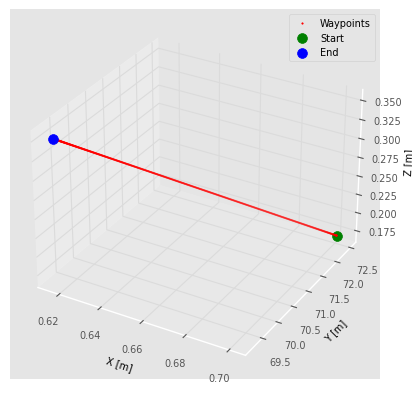

In [8]:

planning.plot_waypoints(waypoints, pos_start, pos_end)


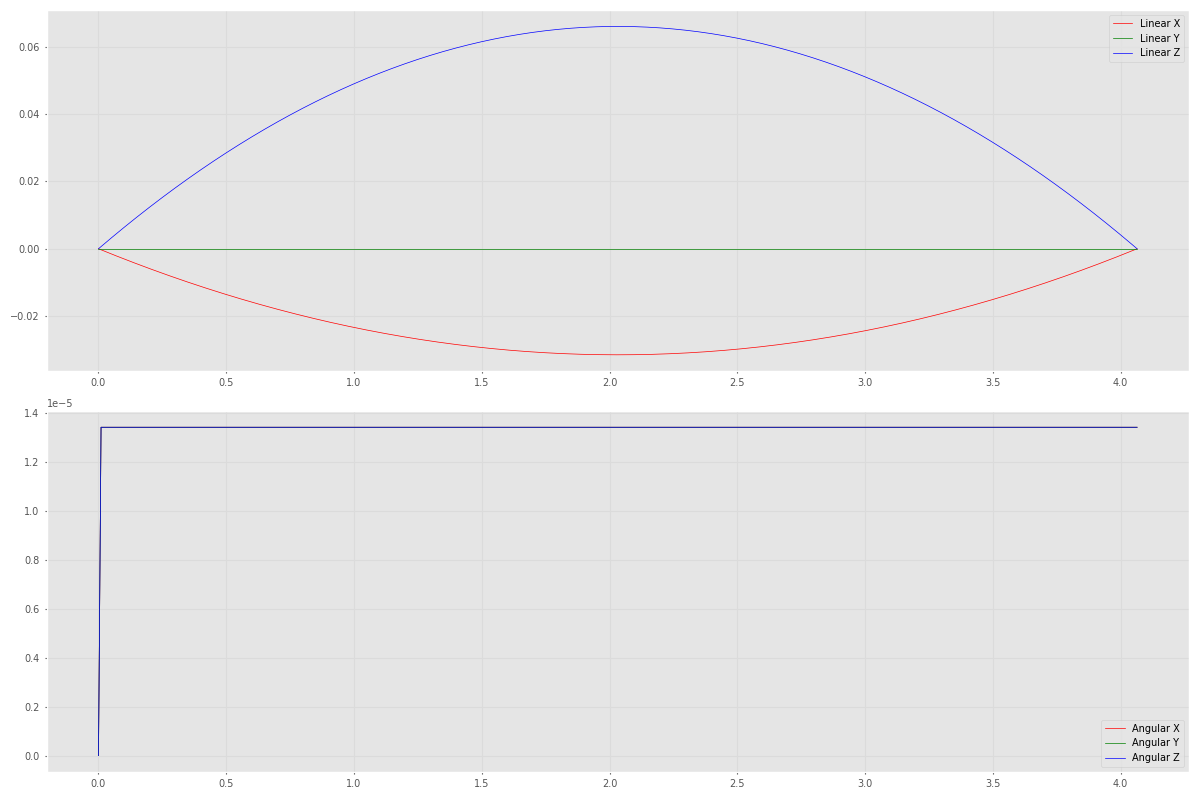

In [9]:
planning.plot_speeds(t_vec, speed_traj, traj_T)

In [ ]:

path = "/content/drive/MyDrive/FRA631_data/joint_trajectory_log.csv"
# name_file = "joint_trajectory_log.csv"
# path = pathlib.Path.cwd() / name_file
print(path)
joint_trajectory = planning.load_joint_trajectory(path)

# Make sure that you have obtained a joint configuration for each waypoint.
if len(joint_trajectory) != len(traj_T):
    raise RuntimeError("Incomplete joint trajectory. Please check IK solutions for all waypoints.")

print("Successfully computed joint trajectory for all waypoints.")


/Users/peeradonruengkaew/Developer/Fibo project/FRA631_Project_Dual_arm_UR5/test/joint_trajectory_log.csv
Successfully computed joint trajectory for all waypoints.


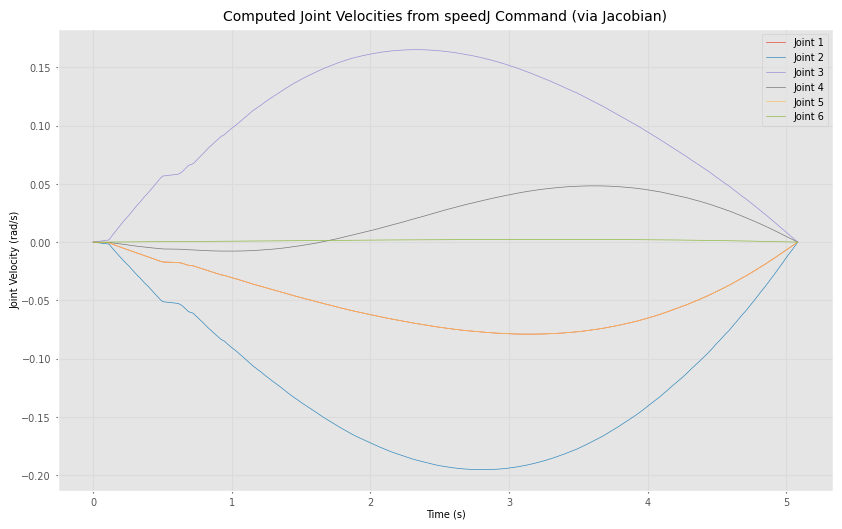

In [17]:
# test speedJ with joint trajectory which not work! try change to speedL is better!

# Control loop time step and joint acceleration.
joint_acceleration = 0.5  # rad/s^2
# Lists to store computed joint velocity commands and time stamps for plotting.
computed_joint_velocities = []  # Each element will be an array of joint velocities (rad/s)
time_stamps = []                 # Record the simulation time for each iteration
start_time = time.time()
for i in range(len(traj_T)):
    current_time = time.time() - start_time
    time_stamps.append(current_time)

    x_dot_des = speed_traj[i, :]  # Desired linear speed
    x_dot_des = np.concatenate((x_dot_des, np.zeros(3)))  # Shape: (6,)
    x_dot_des = np.array(x_dot_des, dtype=float)  # Ensure it's a numpy array
    q_current = joint_trajectory[i]
    # Compute the analytic Jacobian at the current joint configuration.
    J = robotDH.jacobe(q_current)  # J should be a 6x6 matrix.
    # Compute the joint velocities (dq) required to produce the desired TCP velocity.
    # dq = np.linalg.pinv(J).dot(x_dot_des)
    dq = np.linalg.inv(J) @ x_dot_des
    # check sigularity of Jacobian matrix
    if np.linalg.cond(J) < 1e-09:
        print("Jacobian is singular, cannot compute joint velocities.")
        break

    # Store the computed joint velocities for plotting later.
    computed_joint_velocities.append(dq)

    # Send the joint velocity command to the robot using the speedJ command.
    # real_robot.robot_speed_J(dq.tolist(), acceleration=joint_acceleration, time=dt) <---- this line send command real robot

    # Delay to simulate control-loop timing.
    time.sleep(dt)
# Convert the list of computed joint velocities to a numpy array.
computed_joint_velocities = np.array(computed_joint_velocities)  # Shape: (num_steps, num_joints)

# --- Plotting the Computed Joint Velocities ---
plt.figure(figsize=(10, 6))
num_joints = computed_joint_velocities.shape[1]
for j in range(num_joints):
    plt.plot(time_stamps, computed_joint_velocities[:, j], label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities from speedJ Command (via Jacobian)")
plt.legend()
plt.grid(True)
plt.show()


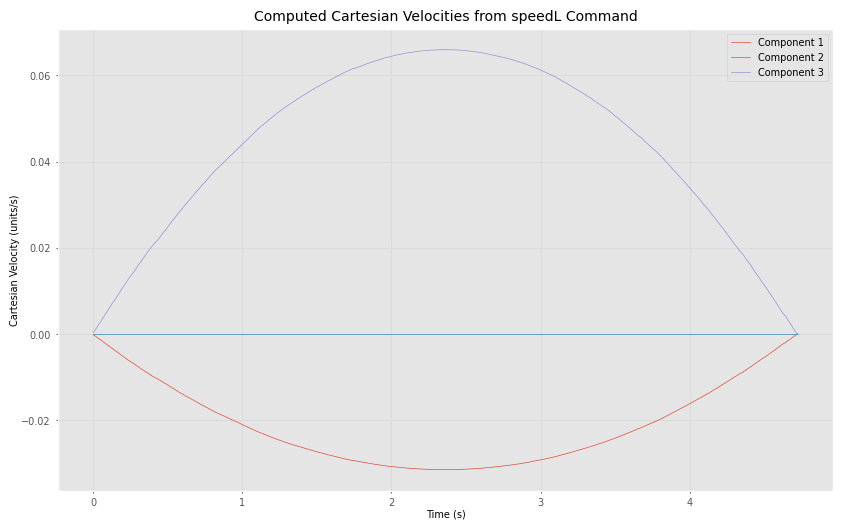

In [18]:
# test with speedL#1 find speed from distance and time

# Control loop time step and Cartesian acceleration (m/s^2)
dt = 0.01  # seconds
cartesian_acceleration = 0.5  # adjust as needed

# Lists to store computed Cartesian velocity commands and time stamps for plotting.
computed_cartesian_velocities = []  # Each element will be a 6D velocity vector: [vx,vy,vz,wx,wy,wz]
time_stamps = []  # To record the simulation time for each iteration

start_time = time.time()

# Loop over each waypoint in your Cartesian trajectory (traj_T).
# This loop simulates a control-loop that sends a Cartesian velocity command using speedL.
for i in range(len(traj_T)):
    current_time = time.time() - start_time
    time_stamps.append(current_time)

    if i < len(traj_T) - 1:
        # Extract the positions from the current and the next pose (assumed to be 3-element vectors)
        pos_current = np.array(traj_T[i].t)
        pos_next = np.array(traj_T[i+1].t)
        # Compute the linear velocity (in m/s) required to go from pos_current to pos_next in time dt.
        v_linear = (pos_next - pos_current) / dt
        # For a pure linear move, we set the rotational (angular) velocity to zero.
        v_tcp = np.concatenate((v_linear, np.zeros(3)))  # Form a 6D velocity vector.
    else:
        # At the final waypoint, we command zero velocity.
        v_tcp = np.zeros(6)

    # Store the computed Cartesian velocity for plotting or verification.
    computed_cartesian_velocities.append(v_tcp)

    # Send the desired Cartesian velocity to the robot using the speedL command.
    # real_robot.robot_move_speed(v_tcp.tolist(), acceleration=cartesian_acceleration, time=dt) <---- this line send command real robot

    time.sleep(dt)  # Maintain the control loop timing

# Convert the velocity list to a NumPy array for plotting.
computed_cartesian_velocities = np.array(computed_cartesian_velocities)

# --- Plotting the computed Cartesian velocities ---
plt.figure(figsize=(10, 6))
for j in range(3):
    plt.plot(time_stamps, computed_cartesian_velocities[:, j], label=f'Component {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Cartesian Velocity (units/s)")
plt.title("Computed Cartesian Velocities from speedL Command")
plt.legend()
plt.grid(True)
plt.show()


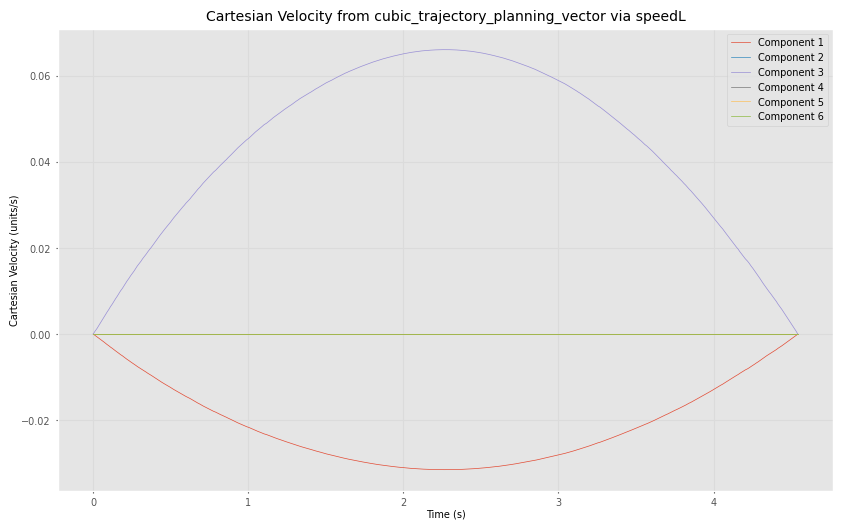

last velocity: [0.00000000e+00 8.47032947e-22 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [19]:
# test with speedL#2 find speed from cubic trajectory

cartesian_acceleration = 0.5  # m/s^2
computed_cartesian_velocities = []  # to store the velocity commands
time_stamps = []
start_time = time.time()

# Loop over the trajectory time vector.
for i in range(len(t_vec)):
    current_time = time.time() - start_time
    time_stamps.append(current_time)

    # Extract the velocity for this timestep from the vel_traj array.
    v_linear = speed_traj[i, :]  # This is a 3-element vector [vx, vy, vz]

    # Construct the full 6D velocity vector (set angular to zero).
    v_tcp = np.concatenate((v_linear, np.zeros(3)))

    computed_cartesian_velocities.append(v_tcp)

    # Now, send the speedL command using your robot's interface.
    # real_robot.robot_move_speed(v_tcp.tolist(), acceleration=cartesian_acceleration, time=dt)

    time.sleep(dt)

computed_cartesian_velocities = np.array(computed_cartesian_velocities)

# Plot the velocity profiles for verification.
plt.figure(figsize=(10, 6))
for j in range(6):
    plt.plot(time_stamps, computed_cartesian_velocities[:, j], label=f'Component {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Cartesian Velocity (units/s)")
plt.title("Cartesian Velocity from cubic_trajectory_planning_vector via speedL")
plt.legend()
plt.grid(True)
plt.show()

print("last velocity:", computed_cartesian_velocities[-1])

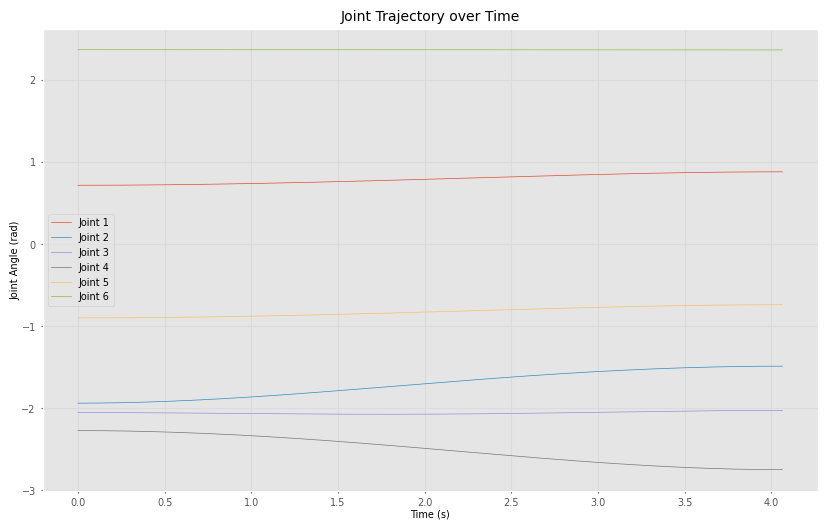

In [20]:
# this see how joint trajectory is smooth or not however
# is not use due to is need to convert to speed and speed each joint is not work for this project!

# First, convert the joint trajectory to a NumPy array for easier manipulation.
joint_traj_array = np.array(joint_trajectory)  # shape: (N, 6)

# Create a time vector that spans the total duration of the trajectory.
# For plotting purposes, you can use T_total (if you already computed it) or simply index the waypoints.
T_total = T_total  # Replace with your actual total time if computed
num_points = joint_traj_array.shape[0]
time_vec = np.linspace(0, T_total, num_points)

# Plot each joint's trajectory
plt.figure(figsize=(10, 6))
for joint_idx in range(joint_traj_array.shape[1]):
    plt.plot(time_vec, joint_traj_array[:, joint_idx],
             label=f"Joint {joint_idx + 1}")

plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (rad)")
plt.title("Joint Trajectory over Time")
plt.legend()
plt.grid(True)
plt.show()
